In [1]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
import numpy as np
import math
import matplotlib.pyplot as plt  
import numba
try:
    profile  # throws an exception when profile isn't defined
except NameError:
    profile = lambda x: x

In [2]:
@numba.jit(nopython=True, nogil=True, cache=False)
def onemove_in_cube_true_numba(p0,v):   
    htime=np.abs((np.floor(p0)-p0+(v>0))/v) #find distance vector to new position
    minLoc=np.argmin(htime) #find min distance location in htime
    dist=htime[minLoc] #find min distance
    htime=p0+dist*v #calculate new position estimate htime
    htime[minLoc]=round(htime[minLoc])+np.spacing(abs(htime[minLoc]))*np.sign(v[minLoc]) #Need this for rounding to next position
    return htime,dist

In [3]:
@numba.jit(nopython=True, nogil=True, cache=False, parralel=True)
def main_loop(Nx,Ny,Nz,Mx,My,D,h,orginOffset,ep,mu):
    detector=np.zeros((Mx,My),dtype=np.float32) #detector Mx x pixels and My y pixels
    for z in range(0,Mx*My): #loop for all pixels
        j=z%Mx #y direction pixel
        i=int(z/Mx) #x direction pixel
        pos=np.array([orginOffset[0]+i*D,orginOffset[1]+D*j, 0],dtype=np.float32) #pixel location
        dir=((ep-pos)/np.linalg.norm(ep-pos)).astype(np.float32) #noramlized direction vector to source
        dir[dir==0]=1e-16 #need this for floating point division errors in Numba
        L=0 # initial energy
        h_z=h+Nz
        while pos[2]< h_z: #loop until the end of imaging volume
            pos,dist=onemove_in_cube_true_numba(pos,dir) #move to next cube
            if 0 <= pos[0] < Nx and 0<=pos[1]<Ny  and h<=pos[2] < h_z: #if in imaging volume
                L+=mu[math.floor(pos[0]),math.floor(pos[1]),math.floor(pos[2]-h)]*dist #calculate energy using mu
        detector[i][j] = L; # detector pixel locaiton equals lasting energy
    return detector

In [4]:
f = h5py.File('headct.h5', 'r') #HDF5 file containing Headct array of linear attenuation coeffcients(Nx,Ny,Nz)
headct=np.array(f.get('ct'))
headct=np.transpose(headct) #linear attenuation coeffceient matrix
det=f.get('det')
det=np.transpose(det) #Result of running this code on Matlab for later comparsion
Nx = np.size(headct,0) #Imaging x dimension length in mm
Ny = np.size(headct,1) #Imaging y dimension length in mm
Nz = np.size(headct,2) #Imaging z dimension length in mm
Mx = 200 #Number of pixels in x direction
My = 200 #Number of pixels in y direction
D = 2 #Size of each pixel in mm
h = 50 #distance(Z) bettween bottom of imaging volume and detector
H = h + Nz + 200 #distance(Z) bettween detector and x-ray source
muBone = 0.573 #linear attenuation coeffcient bone cm^-1
muFat = 0.193 #linear attenuation coeffcient fat cm^-1
orginOffset = np.array(
        [(-Mx * D) / 2 + (Nx / 2), (-My * D) / 2 + (Ny / 2), 0], dtype=np.float32) #offset from origin to detector start (X,Y,Z)
ep = np.array([Nx / 2, Ny / 2, H], dtype = np.float32) #location of x-ray soruce
orginOffset = np.array([(-Mx * D) / 2 + (Nx / 2), (-My * D) / 2 +(Ny / 2), 0],dtype=np.float32) #offset from origin to detector start
mu=np.zeros((Nx,Ny,Nz),dtype=np.float32) #(Nx,Ny,Nz) linear attenuation coeffcient matrix 
mu[np.nonzero(headct>0)]=((headct[np.nonzero(headct>0)]-0.3)/(0.7))*(muBone-muFat)+muFat #Normilization of givens mus of linear attenuation matrix

In [5]:
detA=main_loop(Nx,Ny,Nz,Mx,My,D,h,orginOffset,ep,mu)
detector=np.exp(detA*-10,dtype=np.float64)

In [6]:
print(np.count_nonzero(np.isclose(det,detector,rtol=0.01))>39900)
np.save('Detector.npy',detector)

True


In [ ]:
#Numpy
%timeit onemove_in_cube_true(np.array([1,2,2],dtype='float32'),np.array([.11,.22,.12],dtype='float32'))

In [ ]:
#cython
%timeit move_step.onemove_in_cube_true(np.array([1,2,2],dtype='float32'),np.array([.11,.22,.12],dtype='float32'))

In [ ]:
#Numba No Type
%timeit onemove_in_cube_true_numba(np.array([1,2,2],dtype='float32'),np.array([.11,.22,.12],dtype='float32'))

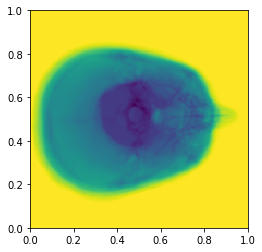

In [7]:
plt.imshow(np.log(det), extent=[0, 1, 0, 1])
plt.show()

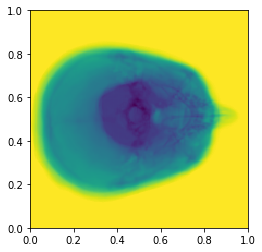

In [8]:
plt.imshow(np.log(detector), extent=[0, 1, 0, 1])
plt.show()